In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Sample rate
sr = 22050

In [3]:
# Util functions
def get_dataset(folder):
    X = []
    ys = []
    f = os.path.join('/kaggle/input/preprocess-audio/' ,folder)
    for filename in os.listdir(f):
        try:
            y, _ = librosa.load(os.path.join(f, filename), sr = sr)
            X.append(y)
            ys.append(int(labels.index(folder)))
        except:
            print(folder + "/" + filename)
    return X, ys
def draw_spectrogram(y, n_fft, hop_length, label):
    D = np.abs(librosa.stft(y, n_fft = n_fft, hop_length = hop_length))
    librosa.display.specshow(librosa.amplitude_to_db(D),y_axis='log', x_axis='time')
    plt.title('Power spectrogram (' + label +')')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()
def draw_waveplot(y, sr):
    librosa.display.waveplot(y, sr)
    plt.tight_layout()
    plt.show()

In [4]:
labels = ['dog bark', 'say go', 'baby cry']

In [5]:
# Get all data
num_samples = {}
X = []
y = []
for folder in labels:
    X_folder, y_folder = get_dataset(folder)
    X += X_folder
    y += y_folder
    num_samples[folder] = len(X_folder)

baby cry/253.wav
baby cry/252.wav


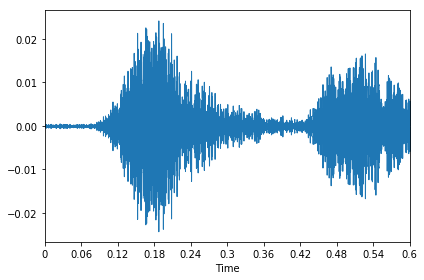

In [6]:
draw_waveplot(X[0], sr)

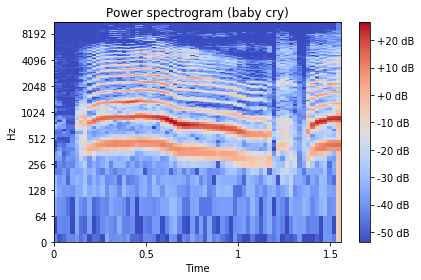

In [7]:
draw_spectrogram(librosa.util.fix_length(X[700], 3 * sr), n_fft = 512, hop_length = 1000, label = labels[y[700]])

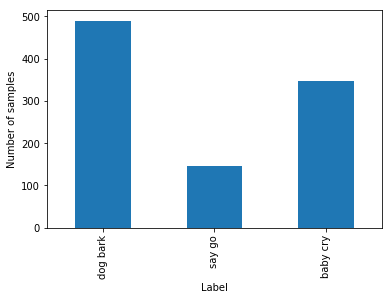

In [8]:
# Number of samples
pd.Series(num_samples).plot.bar()
plt.xlabel("Label")
plt.ylabel("Number of samples");

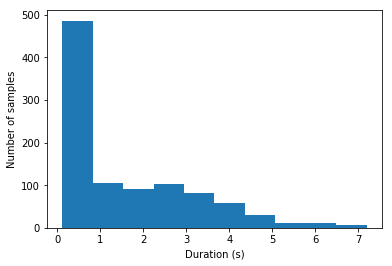

In [9]:
# Length of audios
lengths = [librosa.core.get_duration(s, sr) for s in X]
plt.hist(lengths)
plt.xlabel("Duration (s)")
plt.ylabel("Number of samples")
plt.show()

In [10]:
class FixLength(BaseEstimator, TransformerMixin):
    def __init__(self, length):
        self.length = length * sr
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # X contains tupes of y and sr
        res = []
        for y in X:
            y_fixed = librosa.util.fix_length(y, self.length)
            res.append(y_fixed)
        return res

In [11]:
class STFT(BaseEstimator, TransformerMixin):
    def __init__(self, n_fft = 512, hop_length = 1000):
        self.n_fft = n_fft
        self.hop_length = hop_length
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        res = []
        for y in X:
            y_fft = librosa.amplitude_to_db(np.abs(librosa.core.stft(y, n_fft = self.n_fft, hop_length=self.hop_length))).flatten()
            res.append(y_fft)
        return res

In [12]:
fix_length = FixLength(2)
sfft = STFT()
onehot = OneHotEncoder(handle_unknown='ignore')
X_processed = fix_length.fit_transform(X)
X_processed = sfft.fit_transform(X_processed)
y_processed = onehot.fit_transform(np.array(y).reshape(-1,1))

In [13]:
X_processed[1].shape

(11565,)

In [14]:
# Train val split
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size = 0.2, random_state = 0)

In [15]:
model = MLPClassifier(hidden_layer_sizes=(100,50,20,3), activation='tanh', solver='lbfgs', random_state=0, max_iter=500, verbose=1)

In [16]:
model.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50, 20, 3), learning_rate='constant',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=1, warm_start=False)

In [17]:
model.score(X_val, y_val)

0.9086294416243654

In [18]:
n_ffts = [128, 256, 512, 1024, 4096]
alphas = [100, 10, 1, 0.1, 0.01, 0.001]

val_score = []
train_score = []

for i in n_ffts:
    for alp in alphas:
        sfft = STFT(i)
        X_processed = fix_length.fit_transform(X)
        X_processed = sfft.fit_transform(X_processed)
        X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size = 0.2, random_state = 0)
        model = MLPClassifier(hidden_layer_sizes=(100,50,20,3), activation='tanh', solver='lbfgs', random_state=0, max_iter=500, verbose=1, alpha = alp)
        model.fit(X_train, y_train)
        val_score.append(model.score(X_val, y_val))
        train_score.append(model.score(X_train, y_train))

In [19]:
best_score = max(val_score)
index_max = val_score.index(max(val_score))
best_alp = alphas[index_max%len(alphas)]
best_ntff = n_ffts[index_max//len(n_ffts)]

print (best_alp, best_ntff, best_score)

10 1024 0.934010152284264


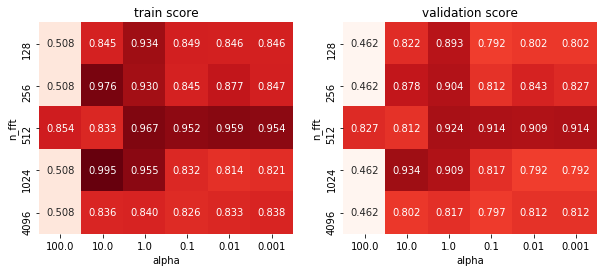

In [20]:
# Trực quan hóa kết quả
import seaborn as sns
train_scores_df = pd.DataFrame(data=np.array(train_score).reshape(len(n_ffts), -1),
                             index=n_ffts, columns= alphas)
val_scores_df = pd.DataFrame(data=np.array(val_score).reshape(len(n_ffts), -1), 
                           index= n_ffts, columns= alphas)
min_score = min(min(train_score), min(val_score))
max_score = max(max(train_score), max(val_score))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_scores_df, vmin=min_score, vmax=max_score, square=True, annot=True, 
            cbar=False, fmt='.3f', cmap='Reds')
plt.title('train score'); plt.ylabel('n_fft'); plt.xlabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_scores_df, vmin=min_score, vmax=max_score, square=True, annot=True, 
            cbar=False, fmt='.3f', cmap='Reds')
plt.title('validation score'); plt.ylabel('n_fft'); plt.xlabel('alpha');